In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# jt -t monokai -cellw 95% -f dejavu -fs 12
from jupyterthemes import jtplot
jtplot.style()

import numpy as np
import os
import pandas as pd
import random
import pickle
import bcolz
from tqdm import tqdm
from IPython.display import FileLink, FileLinks
from IPython.display import SVG

import scipy
from sklearn import preprocessing
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
import cv2

os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot
from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.applications.xception import Xception, preprocess_input

def get_raw(df, data_path):
    im_features = df.copy()

    rgb = []
    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = Image.open(data_path + image_name + '.jpg')
        img = img.resize((imagesize,imagesize))
        img = np.array(img)[:,:,:3]
        # im = np.hstack( ( img[:,:,0].ravel(), img[:,:,1].ravel(), img[:,:,2].ravel() ))
        rgb.append( img )

    return np.array(rgb)

def getEdges(df, data_path):
    im_features = df.copy()

    edgeCountArr = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        edges = cv2.Canny( img, 5, 25)
        edgeCountArr.append( edges )
    
    return np.array(edgeCountArr)

def getDistance(xypair):
    x_delta = abs(xypair[0] - xypair[2])
    y_delta = abs(xypair[1] - xypair[3])
    hypotenuse = (x_delta**2 + y_delta**2)**0.5
    return hypotenuse

def getLines(df, data_path):
    im_features = df.copy()

    lineArr = []
    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        edges = cv2.Canny( img, 100, 125)

        lines = cv2.HoughLinesP(edges,1,np.pi/180,25,minLineLength=25,maxLineGap=50)
        zeros = np.zeros((imagesize, imagesize))
        
        if lines is None:
            lineArr.append( zeros )
            
        else:
            for line in lines:
                x1,y1,x2,y2 = line[0]
                cv2.line(zeros,(x1,y1),(x2,y2),(255),1)
            lineArr.append( zeros )
    
    return np.array(lineArr)

def getCorners(df, data_path):
    im_features = df.copy()

    cornerArr = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        img = cv2.imread( data_path + image_name + '.jpg' , 0)
        img = cv2.resize(img, (imagesize, imagesize))
        img = np.float32(img)
        dst = cv2.cornerHarris(img,2,3,0.04)

        thresholdIndices = dst > 0.05 * dst.max()
        matrix = np.zeros(shape=(dst.shape[0],dst.shape[1]))
        matrix[thresholdIndices] = 1
        cornerArr.append( matrix )

    return np.array(cornerArr)

def extract_features(df, data_path):
    im_features = df.copy()

    r_mean = []
    g_mean = []
    b_mean = []

    r_std = []
    g_std = []
    b_std = []

    r_max = []
    g_max = []
    b_max = []

    r_min = []
    g_min = []
    b_min = []

    r_kurtosis = []
    g_kurtosis = []
    b_kurtosis = []
    
    r_skewness = []
    g_skewness = []
    b_skewness = []

    for image_name in tqdm(im_features.image_name.values, mininterval=10): 
        im = Image.open(data_path + image_name + '.jpg')
        im = np.array(im)[:,:,:3]

        r_mean.append(np.mean(im[:,:,0].ravel()))
        g_mean.append(np.mean(im[:,:,1].ravel()))
        b_mean.append(np.mean(im[:,:,2].ravel()))

        r_std.append(np.std(im[:,:,0].ravel()))
        g_std.append(np.std(im[:,:,1].ravel()))
        b_std.append(np.std(im[:,:,2].ravel()))

        r_max.append(np.max(im[:,:,0].ravel()))
        g_max.append(np.max(im[:,:,1].ravel()))
        b_max.append(np.max(im[:,:,2].ravel()))

        r_min.append(np.min(im[:,:,0].ravel()))
        g_min.append(np.min(im[:,:,1].ravel()))
        b_min.append(np.min(im[:,:,2].ravel()))

        r_kurtosis.append(scipy.stats.kurtosis(im[:,:,0].ravel()))
        g_kurtosis.append(scipy.stats.kurtosis(im[:,:,1].ravel()))
        b_kurtosis.append(scipy.stats.kurtosis(im[:,:,2].ravel()))
        
        r_skewness.append(scipy.stats.skew(im[:,:,0].ravel()))
        g_skewness.append(scipy.stats.skew(im[:,:,1].ravel()))
        b_skewness.append(scipy.stats.skew(im[:,:,2].ravel()))


    im_features['r_mean'] = r_mean
    im_features['g_mean'] = g_mean
    im_features['b_mean'] = b_mean

    im_features['r_std'] = r_std
    im_features['g_std'] = g_std
    im_features['b_std'] = b_std

    im_features['r_max'] = r_max
    im_features['g_max'] = g_max
    im_features['b_max'] = b_max

    im_features['r_min'] = r_min
    im_features['g_min'] = g_min
    im_features['b_min'] = b_min

    im_features['r_kurtosis'] = r_kurtosis
    im_features['g_kurtosis'] = g_kurtosis
    im_features['b_kurtosis'] = b_kurtosis
    
    im_features['r_skewness'] = r_skewness
    im_features['g_skewness'] = g_skewness
    im_features['b_skewness'] = b_skewness
    
    return np.array(im_features.drop(['image_name', 'tags'], axis=1))

# def extract_features(df, data_path):
#     im_features = df.copy()

#     histArr = []

#     for image_name in tqdm(im_features.image_name.values, mininterval=10): 
#         img = cv2.imread( folderpath + 'train-jpg/train_0.jpg' )
#         img = np.array(img)
#         img.shape

#         R = img[:,:,0]
#         G = img[:,:,1]
#         B = img[:,:,2]

#         RGBHistArr = []

#         for channel in [R,G,B]:
#             placeholder = np.zeros( (256) )
#             unique, counts = np.unique(R, return_counts=True)
#             placeholder[unique] = counts
#             RGBHistArr.append(placeholder)

#         histArr.append( np.hstack(tuple(RGBHistArr)) )
        
#     histArr = np.array(histArr).astype('float32')
    
#     return histArr

def splitSet(dataset, split1, split2):
    idx_split1 = int( len(dataset) * split1)
    idx_split2 = int( len(dataset) * split2)

    training = dataset[0:idx_split1]
    validation = dataset[idx_split1:idx_split2]
    test = dataset[idx_split2:] 

    return [ training, validation, test ]

def tf_th_ImgReshape(data):
    shapedData = [ np.array( [sample[:,:,0] , sample[:,:,1] , sample[:,:,2]] ) for sample in data]
    return np.array(shapedData)

def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def xceptionPreprocess(rawFeatures):
    rawFeatures = rawFeatures.astype('float32')
    rawFeatures = preprocess_input(rawFeatures)
    return rawFeatures

def shapingDataSet(rawFeatures, edgeFeatures):
    edgeFeaturesShaped = np.reshape(edgeFeatures, edgeFeatures.shape + (1,))
    X = [ np.dstack((sampleRaw, sampleEdge)) for sampleRaw, sampleEdge in zip(rawFeatures, edgeFeaturesShaped) ]
    X = np.array(X)
    X = X.astype('float32')
    X -= 127
    X /= 255
    return X

def dataGenerator(imgRGBArr, imgStatsArr, imgLabels, labelsBool=True, loopBool=True):
    batchsize = 32
    while 1 and loopBool == True:
        for idx in range(0, len(imgRGBArr), batchsize):
            imgRGB = xceptionPreprocess(imgRGBArr[idx:idx+batchsize])
            imgStat = imgStatsArr[idx:idx+batchsize]
            labels = imgLabels[idx:idx+batchsize]
            if labelsBool == True:
                yield ({'xception_input': imgRGB, 'aux_input': imgStat}, {'output': labels})
            else:
                yield ({'xception_input': imgRGB, 'aux_input': imgStat})

def getLabelDistribution(labels, labelNameArray):
    labelCount = [ np.sum(labels[:,i]) for i in range(0, len(labels[0])) ]
    labelNameCount = {key: val for key, val in zip(labelNameArray, labelCount)}

    return labelNameCount, labelCount

def getPrecision(labels, predictions):
    # False positive is a negative label but positive prediction
    Tp = float(0)
    Fp = float(0)
    for label, prediction in zip(labels, predictions):
        try:
            len(label)
        except:
            label = [label]
            prediction = [prediction]
        for idx in range(0, len(label)):
            if label[idx]==1 and prediction[idx]==1:
                Tp += 1
            if label[idx]==0 and prediction[idx]==1:
                Fp += 1

    if Tp+Fp == 0:
        return 0

    return (Tp / ( Tp + Fp ))

def getRecall(labels, predictions):
    # False negative is a positive label but negative prediction
    Tp = float(0)
    Fn = float(0)
    for label, prediction in zip(labels, predictions):
        try:
            len(label)
        except:
            label = [label]
            prediction = [prediction]
        for idx in range(0, len(label)):
            if label[idx]==1 and prediction[idx]==1:
                Tp += 1
            if label[idx]==1 and prediction[idx]==0:
                Fn += 1

    if Tp+Fn == 0:
        return 0
    
    return (Tp / ( Tp + Fn ))

assert_label = [
[0,0,0],
[0,1,0],
[0,1,0]
]

assert_pred = [
[0,0,0],
[0,0,1],
[1,1,0]
]

assert getPrecision(assert_label, assert_pred) == float(1)/3
assert getRecall(assert_label, assert_pred) == 0.5

assert_label2 = [[0], [1], [1]]
assert_pred2 = [[0], [1], [0]]

assert getPrecision(assert_label2, assert_pred2) == 1.0
assert getRecall(assert_label2, assert_pred2) == 0.5

def getStatistics(labels, predictions, labelNames):
    precision = [ getPrecision(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    recall = [ getRecall(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    f1 = [ f1_score(labels[:, col], predictions[:, col]) for col in range(0, len(labels[0])) ]
    
    precision = np.array(precision)
    recall = np.array(recall)

    labelPR = {labelName: (precision[idx], recall[idx]) for idx, labelName in enumerate(labelNames)}

    return labelPR, precision, recall, f1

def errorAnalyticsBarGraph(test_labels, test_predictions, labels):
    _, labelCounts = getLabelDistribution(test_labels, labels)
    labelPercentage = np.array( [ np.array([ count / np.sum(labelCounts) ]) for count in labelCounts ] )
    _, precision, recall, f1 = getStatistics(test_labels, test_predictions, labels)

    plt.rcParams['figure.figsize'] = (14, 8)
    fig, ax = plt.subplots()
    index = np.arange(len(labels))
    bar_width = 0.20
    opacity = 0.8

    rects1 = plt.bar(index, f1, bar_width,
                     alpha=opacity,
                     color='#6A93C6',
                     label='F1')

    rects2 = plt.bar(index + bar_width, precision, bar_width,
                     alpha=opacity,
                     color='#C3C2BD',
                     label='Precision')

    rects3 = plt.bar(index + bar_width + bar_width, recall, bar_width,
                     alpha=opacity,
                     color='#DFDFE2',
                     label='Recall')

    rects4 = plt.bar(index + bar_width + bar_width + bar_width, labelPercentage, bar_width,
                     alpha=opacity,
                     color='#7BE686',
                     label='Percentage')

    plt.xlabel('Label')
    plt.ylabel('Scores')
    plt.title('Scores by Label')
    plt.xticks(rotation=70, fontsize=14, fontweight='bold')
    plt.xticks(index + bar_width, (label for label in labels))
    plt.yticks(fontsize=14, fontweight='bold')
    plt.legend()

    plt.tight_layout()
    plt.show()

Using TensorFlow backend.


In [2]:
imagesize = 299
cutOff = 0.25

# Load data
folderpath = os.getcwd() + '/'
train_path = folderpath+'train-jpg/'
test_path = folderpath+'test-jpg/'
train = pd.read_csv(folderpath+'train.csv')
test = pd.read_csv(folderpath+'sample_submission_v2.csv')

In [3]:
print('Extracting Dataset Features')
rerun = False

if rerun == True:
    train_ImgRaw = get_raw(train, train_path)
#     train_ImgEdge = getEdges(train, train_path)
#     train_ImgLine = getLines(train, train_path)
#     train_ImgCorner = getCorners(train, train_path)
    train_ImgStats = extract_features(train, train_path)
    
    data_dic = {'pickleImgRaw': train_ImgRaw, 
#                 'pickleImgEdge': train_ImgEdge, 
#                 'pickleImgLine': train_ImgLine, 
#                 'pickleImgCorner': train_ImgCorner, 
                'pickleImgStats': train_ImgStats
               }
    
    for key in data_dic:
        save_array(folderpath+key, data_dic[key])

else:
    train_ImgRaw = load_array('pickleImgRaw')
#     train_ImgEdge = load_array('pickleImgEdge')
#     train_ImgLine = load_array('pickleImgLine')
#     train_ImgCorner = load_array('pickleImgCorner')
    train_ImgStats = load_array('pickleImgStats')

Extracting Dataset Features


In [4]:
# # Reviewing image features
# imgidx = 62
# plt.subplot(131),plt.imshow(train_ImgRaw[imgidx] )
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(132),plt.imshow(train_ImgLine[imgidx] ,cmap = 'gray')
# plt.title('line Image'), plt.xticks([]), plt.yticks([])
# plt.subplot(133),plt.imshow(train_ImgCorner[imgidx] ,cmap = 'gray')
# plt.title('Corner Image'), plt.xticks([]), plt.yticks([])
# plt.show()

In [4]:
# print('Setup Dataset Labels')
y_train = []

# flatten = lambda l: [item for sublist in l for item in sublist]
# labels = np.array(list(set(flatten([l.split(' ') for l in train['tags'].values]))))
labels = np.array(['clear', 'partly_cloudy', 'cloudy', 'haze', 'primary', 'water', 'bare_ground', 
    'agriculture', 'cultivation', 'habitation', 'road', 'conventional_mine', 'artisinal_mine', 
    'selective_logging', 'slash_burn', 'blooming', 'blow_down'])

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for tags in train.tags.values:
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_train.append(targets)
    
y = np.array(y_train).astype('float32')

In [10]:
# Multi run averaging of random forest results
# train_ImgStats = load_array('pickleImgStats')
X_stats = train_ImgStats

random_seed = 0
random.seed(random_seed)
npRandomSeed = np.random.seed(random_seed)

numberRuns = 3

runResultsArr = []
for _ in range(numberRuns):
    randArr = np.array(range(len(y)))
    np.random.shuffle( randArr )
    
    X_shuffled = X_stats[randArr]
    y_shuffled = y[randArr]
    
    train_dataset_stats, valid_dataset_stats, test_dataset_stats = splitSet(X_shuffled, 0.8, 0.9)
    train_labels, valid_labels, test_labels = splitSet(y_shuffled, 0.8, 0.9)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf = clf.fit(train_dataset_stats, train_labels)
    
    test_predictions = [ clf.predict(test_chip.reshape(1,-1))[0] for test_chip in tqdm(test_dataset_stats, mininterval=10) ]
    test_predictions_threshold = np.array(test_predictions).astype('int')
    runResultsArr.append({'prediction':test_predictions_threshold,'labels': test_labels})
    pickle.dump(runResultsArr, open(folderpath+'rf_rgbstats_results', 'wb'))


100%|██████████| 4048/4048 [01:31<00:00, 44.33it/s]


In [5]:
# print('Shaping Dataset')
# Image RGB Features
X_img = train_ImgRaw

# Image Statistics features
X_stats = train_ImgStats.astype('float32')
scaler = preprocessing.StandardScaler().fit(X_stats)
X_stats = scaler.transform(X_stats)

In [6]:



# check = ModelCheckpoint("weights.{epoch:02d}-{val_acc:.5f}.hdf5", monitor='val_acc', verbose=1, 
#                         save_best_only=True, save_weights_only=True, mode='auto')
earlyStop = EarlyStopping(monitor='val_loss')
tensorBoard = TensorBoard(log_dir='./logs')

def setupModel():
    base_model = Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(299,299,3))
    base_model.layers[0].name = 'xception_input'
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2048, activation='relu', name='xception_output')(x)
    x = Dropout(0.5)(x)

    auxiliary_input = Input(shape=(18,), name='aux_input')

    x = concatenate([x, auxiliary_input])

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(17, activation='sigmoid', name='output')(x)

    model = Model(inputs=[base_model.input, auxiliary_input], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    initialWeights = model.get_weights()
    return model

In [ ]:
# Multi run averaging of random forest results
# train_ImgStats = load_array('pickleImgStats')
runName = 'xceptionraw_rgbnn'
numberRuns = 3

random_seed = 0
random.seed(random_seed)
npRandomSeed = np.random.seed(random_seed)
runResultsArr = []
for runNum in range(numberRuns):
    randArr = np.array(range(len(y)))
    np.random.shuffle( randArr )
    
    X_img_shuffled = X_img[randArr]
    X_stats_shuffled = X_stats[randArr]
    y_shuffled = y[randArr]
    
    train_dataset_img, valid_dataset_img, test_dataset_img = splitSet(X_img_shuffled, 0.5, 0.75)
    train_dataset_stats, valid_dataset_stats, test_dataset_stats = splitSet(X_stats_shuffled, 0.5, 0.75)
    train_labels, valid_labels, test_labels = splitSet(y_shuffled, 0.5, 0.75)
    
    model = setupModel()
    
    model.fit( [xceptionPreprocess(train_dataset_img), train_dataset_stats], train_labels, 
          batch_size=128, epochs=1, callbacks=[earlyStop, tensorBoard], 
          validation_data=([valid_dataset_img, valid_dataset_stats], valid_labels) )
    
    test_predictions = model.predict([xceptionPreprocess(test_dataset_img), test_dataset_stats], batch_size=64, verbose=1)
    
    test_predictions_threshold = np.copy(test_predictions)
    test_predictions_threshold[test_predictions_threshold < cutOff ] = 0
    test_predictions_threshold[test_predictions_threshold >= cutOff ] = 1
    test_predictions_threshold = test_predictions_threshold.astype('int')
    test_labels = test_labels.astype('int')
    
    runResultsArr.append({'prediction':test_predictions_threshold,'labels': test_labels})
    pickle.dump(runResultsArr, open(folderpath+'cnn_rawrgb_results', 'wb'))
    model.save(folderpath+'my_model_'+runName+str(runNum)+'.h5')

# model.save(folderpath+'my_model_yesrgbstats2.h5')
# model = load_model('my_model.h5')
# model.load_weights(folderpath+'weights.03-0.95024.hdf5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


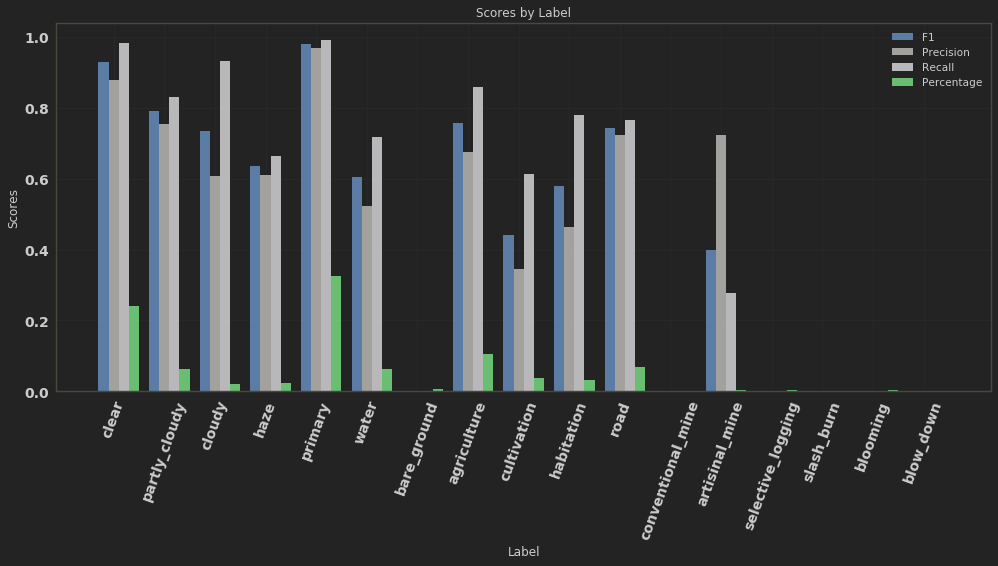

[0.75735, 0.80441, 0.79238, 0.81462, 0.79401]
0.79173


In [11]:
# Analytics
fBetaArr = []
for _ in runResultsArr:
    fBetaArr.append( fbeta_score(_['labels'], _['prediction'], 0.5, average='micro') )

combinedPredictions = np.vstack(tuple([run['prediction'] for run in runResultsArr]))
combinedLabels = np.vstack(tuple([run['labels'] for run in runResultsArr]))

errorAnalyticsBarGraph(combinedLabels, combinedPredictions, labels)
print( [float("%.5f" % i) for i in fBetaArr] )
print("%.5f" % fbeta_score(combinedLabels, combinedPredictions, 0.5, average='micro') )

Labels 
['selective_logging', 'conventional_mine', 'partly_cloudy',
'artisinal_mine', 'haze', 'slash_burn', 'primary', 'clear',
'bare_ground', 'blooming', 'water', 'road', 'cloudy', 'habitation',
'agriculture', 'blow_down', 'cultivation']

Training set label distribution
{'slash_burn': 209.0, 'blooming': 332.0, 'water': 7262.0, 'cloudy': 2330.0, 'selective_logging': 340.0,
 'road': 8076.0, 'primary': 37840.0, 'clear': 28203.0, 'haze': 2695.0, 'agriculture': 12338.0, 'cultivation': 4477.0, 
 'partly_cloudy': 7251.0, 'bare_ground': 859.0, 'conventional_mine': 100.0, 'artisinal_mine': 339.0, 
 'habitation': 3662.0, 'blow_down': 98.0}

# Run Notes

Iter1.
loss: 0.2231 - acc: 0.9143 Single epoch 80% training data 

Iter2.
los: 0.2166 - acc: 0.9166 Modified scaling of inputs to subtract 127 and divide by 255

Iter3.
loss: 0.2028 - acc: 0.9234 Changed convultions to 64, 64, 128, 128, while adding an additional 512 dense layer. Also switched to RMSprop optimizer

Iter4.
val_loss: 0.1344 - val_acc: 0.9502 Using new model and RMSprop, trained for roughly 5 epochs. Likely due to better learning rate decay definition. Previously with SGD, it slowed down excessively towards the end of the epoch.

Rerunning baseline with 80% data and one epoch got val_loss: 0.1750 - val_acc: 0.9341. Trained model for 5 epochs on all data and got a submission score of 0.86942.

Iter5.
Utilizing Xception model and fine-tuning output layer. Final for standard 80%/single_epoch had accuracy of around ~0.93. But error analytics show much better results for bare ground, cultivation, habitation,  artisianal mining, water, and road.

Preprocessing the input using the provided preprocessor improved the result to val_loss: 0.1274 - val_acc: 0.9516

Iter6.
Training all data with the latest model provided a result of loss: 0.1074 - acc: 0.9585. The submission set scored at .89095

Iter 7.
Increased last dense layer to four times the number of nodes to 4096. However, it failed to yield marked better results achieving only loss 0.1145 - acc: 0.9554 at the third epoch. In addition, accuracy actually deteriorated on the 2nd epoch.

Iter8.
Tried adding additional dense layer of 1024 nodes to end. However, it also failed to yield better results achieving loss: 0.1151 - acc: 0.9557 - val_loss: 0.1203 - val_acc: 0.9545 after four epochs. With loss: 0.1639 - acc: 0.9382 - val_loss: 0.1285 - val_acc: 0.9513 after one epoch.

Iter9.
Tried incorporating RGB statistics which claimed loss: 0.1370 - acc: 0.9486 - val_loss: 0.1292 - val_acc: 0.9509 after one epoch. But the test set analysis looked terrible, it's probably overfitting and failing to generalize.

Actually, running it a second time but scaling across the entire statistics dataset then breaking down into training/valid/test sets rather than scaling based on the training set and applying it to the valid/test sets resulted in loss: 0.1370 - acc: 0.9486 - val_loss: 0.1292 - val_acc: 0.9509 with test set error statistics that looked much better. Potentially I made a mistake in applying the preprocessing on the test set, since the validation accuracy was also good. Either way it's looking promising after doing so well after a single epoch. Will try training for 5 epochs on entire dataset.

After 5 epochs on entire dataset achieved loss: 0.0987 - acc: 0.9619 with consistent incremental improvement from each epoch. Will try training for longer. Model predictions on submission set resulted in an almost 1% improvement, 0.89886

After another additional 5 epochs it achieved an improvement of loss: 0.0810 - acc: 0.9682. However, when applied to the submission set, the score dipped slightly to 0.89420, suggesting that it's overfitting.

Iter10.
Testing using RGB histogram instead of aggregate statistics. 80% data and one epoch resulted in: loss: 0.1635 - acc: 0.9370 - val_loss: 0.1290 - val_acc: 0.9509. After five epochs resulted in: loss: 0.1109 - acc: 0.9569 - val_loss: 0.1207 - val_acc: 0.9546 with very little improvement from epoch one.

Iter11.
Using previous xception and rgbhistogram, but increasing initial dense layer to 2048 matching original literature, adding drop out, and adding an additional dense layer to the end. Performance capped out around loss: 0.1345 - acc: 0.9504 - val_loss: 0.1386 - val_acc: 0.9518

Review Iter.
Pulling back and reviewing 

Try converting image into RGB histograms and merging that with final dense layer

Potential additions edge and line analysis can be combined with RGB statistics.

Canny edge analysis and count how many 1s are there.

Line edge analysis and count how many 1s are there.

Corner analysis and count how many 1s are there.

Modify RGB statistics to Purple, Blue, Green, Yellow, Red, Brown, White, Black?

Check misclassification statistics

Utilize an ensemble algorithm, so maybe a Random forest for color + edge statistics, and a separate like a CNN trained specifically to look for specific labels like blow down. This image feature algorithm may potentially use artificially generated data.

In [3]:
model = load_model(folderpath+'final_model.h5')

In [ ]:
model = setupModel()

In [ ]:
##### SUBMISSION RUN #####
# Making Final Predictions using all training data
model.fit( [X_img, X_stats], y, 
          batch_size=128, epochs=2)

Epoch 1/2
40479/40479 [==============================] - 1003s - loss: 0.1572 - acc: 0.9424     

In [ ]:
model.save(folderpath+'final_model.h5')
# model = load_model(folderpath+'final_model.h5')

In [8]:
# print('Making submission predictions')
rerun = False

if rerun == True:
    submission_ImgRaw = get_raw(test, test_path)
#     submission_ImgEdge = getEdges(test, test_path)
#     submission_ImgLine = getLines(test, test_path)
#     submission_ImgCorner = getCorners(test, test_path)
    submission_ImgStats = extract_features(test, test_path)
    
    data_dic = {'submissionPickleImgRaw': submission_ImgRaw, 
#                 'submissionPickleImgEdge': submission_ImgEdge, 
#                 'submissionPickleImgLine': submission_ImgLine, 
#                 'submissionPickleImgCorner': submission_ImgCorner, 
                'submissionPickleImgStats': submission_ImgStats
               }
    
    for key in data_dic:
        save_array(folderpath+key, data_dic[key])

else:
    submission_ImgRaw = load_array('submissionPickleImgRaw')
#     submission_ImgEdge = load_array('submissionPickleImgEdge')
#     submission_ImgLine = load_array('submissionPickleImgLine')
#     submission_ImgCorner = load_array('submissionPickleImgCorner')
    submission_ImgStats = load_array('submissionPickleImgStats')

FileNotFoundError: [Errno 2] No such file or directory: 'submissionPickleImgRaw/meta/sizes'

In [10]:
train_ImgStats = extract_features(train, train_path)
X_stats = train_ImgStats.astype('float32')
scaler = preprocessing.StandardScaler().fit(X_stats)
pickle.dump(scaler, open(folderpath+'scaler', 'wb'))

In [6]:
scaler = pickle.load(open(folderpath+'scaler', 'rb'))

In [7]:
def batchSet(dataset, batches):
    arr = []
    stepSize = int(len(dataset)/batches)
    for idx in range(0, len(dataset), stepSize):
        arr.append(dataset[idx:idx+stepSize])
    return arr

In [8]:
submision_subsetRGBArr = batchSet(submission_ImgRaw, 10)
submision_subsetStatsArr = batchSet(submission_ImgStats, 10)

In [9]:
submission_predictions = []

for idx in range(0, len(submision_subsetRGBArr)):
    subSetRGB = xceptionPreprocess(submision_subsetRGBArr[idx])
    subSetStats = scaler.transform(submision_subsetStatsArr[idx])
    
    submission_subSetPredictions = model.predict([subSetRGB, subSetStats], batch_size=64, verbose=1)
    submission_predictions.append(submission_subSetPredictions)

1/1 [==============================] - 0s


In [10]:
submission_predictionsCombined = np.vstack( tuple(submission_predictions) )

In [11]:
submission_predictions_thresholded = np.copy(submission_predictionsCombined)
submission_predictions_thresholded[submission_predictions_thresholded < cutOff ] = 0
submission_predictions_thresholded[submission_predictions_thresholded >= cutOff ] = 1

predictionLabels = [' '.join(labels[row > 0.2]) for row in submission_predictions_thresholded]

subm = pd.DataFrame()
subm['image_name'] = test.image_name.values
subm['tags'] = predictionLabels
subm.to_csv(folderpath+'submission.csv', index=False)